In [1]:
import librosa
import numpy as np

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)  # Load 30s of audio
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        # Combine features: mean & std of MFCC, mean of chroma & contrast
        features = np.hstack([
            np.mean(mfcc, axis=1),
            np.std(mfcc, axis=1),
            np.mean(chroma, axis=1),
            np.mean(contrast, axis=1)
        ])
        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


Convert Audio to Mel Spectrograms

In [6]:
import librosa
import numpy as np

def audio_to_melspectrogram(file_path, n_mels=128):
    y, sr = librosa.load(file_path, duration=30)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)  # Convert to dB
    return S_DB


 Load Data and Convert to Spectrogram Tensors

In [3]:
import torch

def get_data_and_labels(data_dir, genres, img_size=(128, 660)):
    X = []
    y = []

    for label_idx, genre in enumerate(genres):
        genre_dir = os.path.join(data_dir, genre)
        for filename in os.listdir(genre_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_dir, filename)
                try:
                    mel = audio_to_melspectrogram(file_path)
                    if mel.shape[1] < img_size[1]:  # pad to consistent size
                        mel = np.pad(mel, ((0, 0), (0, img_size[1] - mel.shape[1])), mode='constant')
                    else:
                        mel = mel[:, :img_size[1]]

                    mel = (mel - mel.min()) / (mel.max() - mel.min())  # Normalize 0–1
                    X.append(mel)
                    y.append(label_idx)
                except Exception as e:
                    print(f"Error on {file_path}: {e}")

    X = np.array(X)
    X = X[:, np.newaxis, :, :]  # Add channel dim: (N, 1, H, W)
    y = np.array(y)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


CNN Model for Spectrograms

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 165, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (16, 64, 330)
        x = self.pool(F.relu(self.conv2(x)))  # (32, 32, 165)
        x = x.view(x.size(0), -1)             # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


Training the CNN

In [9]:
import os
import numpy as np
import torch
import librosa
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


In [ ]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

# Now you can extract data
X_data, y_data = get_data_and_labels("Data/genres_original", genres)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)


C:\Users\akash\AppData\Local\Temp\ipykernel_1804\2195989930.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)
c:\Audio\venv\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error on Data/genres_original\jazz\jazz.00054.wav: 


Visualising

In [11]:
import matplotlib.pyplot as plt
import librosa
import librosa.display


In [ ]:
files = {
    'blues': "Data/genres_original/blues/blues.00001.wav",
    'classical': "Data/genres_original/classical/classical.00002.wav",
    'hiphop': "Data/genres_original/hiphop/hiphop.00003.wav",
    'rock': "Data/genres_original/rock/rock.00004.wav"
}


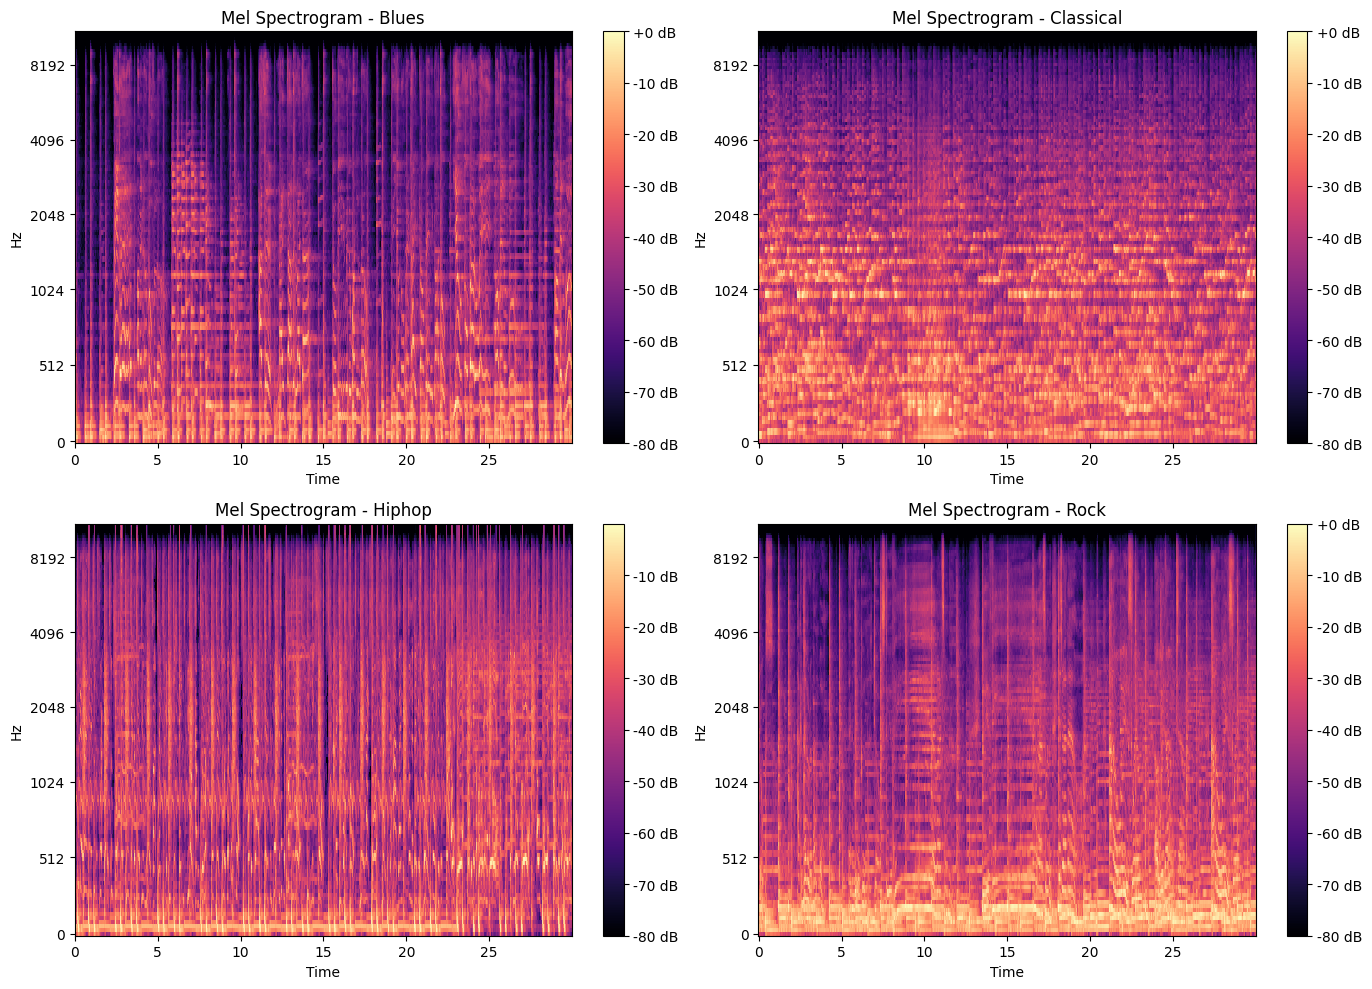

In [14]:
plt.figure(figsize=(14, 10))

for i, (genre, file_path) in enumerate(files.items(), 1):
    try:
        y, sr = librosa.load(file_path, duration=30)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)

        plt.subplot(2, 2, i)
        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram - {genre.capitalize()}')
        plt.tight_layout()

    except Exception as e:
        print(f"Error loading {genre}: {e}")

plt.show()


Import Your CNN Model Class

In [ ]:
from cnn_model import SpectrogramCNN


Recreate the Model

In [ ]:
model = SpectrogramCNN(num_classes=len(genres))


Load the Trained Weights

In [ ]:
import torch

model.load_state_dict(torch.load('model/spectrogram_cnn.pth', map_location=torch.device('cpu')))
model.eval()


SpectrogramCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=168960, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Evaluate the Model

✅ Test Accuracy: 53.00%


c:\Audio\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


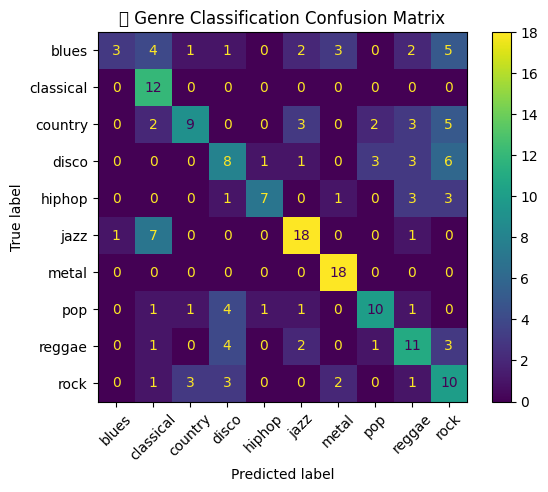

              precision    recall  f1-score   support

       blues       0.75      0.14      0.24        21
   classical       0.43      1.00      0.60        12
     country       0.64      0.38      0.47        24
       disco       0.38      0.36      0.37        22
      hiphop       0.78      0.47      0.58        15
        jazz       0.67      0.67      0.67        27
       metal       0.75      1.00      0.86        18
         pop       0.62      0.53      0.57        19
      reggae       0.44      0.50      0.47        22
        rock       0.31      0.50      0.38        20

    accuracy                           0.53       200
   macro avg       0.58      0.55      0.52       200
weighted avg       0.58      0.53      0.51       200



In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        predicted_labels = torch.argmax(preds, axis=1)
        all_preds.extend(predicted_labels.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(xticks_rotation=45, cmap='viridis')
plt.title("🎵 Genre Classification Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=genres))


In [22]:
# Save the trained model
torch.save(model.state_dict(), 'model/spectrogram_cnn.pth')
